In [4]:
%matplotlib inline

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import cv2

from skimage.transform import resize
from sklearn.model_selection import train_test_split

from keras.models import Sequential, Model
from keras.layers import Dense, Input, Conv2D, MaxPool2D, UpSampling2D, BatchNormalization, Flatten, Dropout, MaxPooling2D, Conv2DTranspose
from keras.layers.merge import concatenate

#from imgaug import augmenters
from sklearn.metrics import confusion_matrix

from tensorflow.keras.optimizers import Adam

import skimage.color as color
from skimage.io import imread
import skimage.feature as feat

In [7]:
#folders = 'D:\\Marko\\ML\\coding examples\\Databases\\BG removing\\XPIE\\'
folders = 'D:\\Marko\\ML\\coding examples\\Databases\\BG removing\\images224-224\\'
face_cascade1 = cv2.CascadeClassifier('D:\\Marko\\ML\\Anaconda3\\lib\\site-packages\\cv2\\data\\haarcascade_frontalface_default.xml')
#face_cascade = cv2.CascadeClassifier('D:\\Marko\\ML\\Anaconda3\\lib\\site-packages\\cv2\\data\\haarcascade_frontalface_default.xml')
face_cascade2 = cv2.CascadeClassifier('D:\\Marko\\ML\\Anaconda3\\lib\\site-packages\\cv2\\data\\haarcascade_fullbody.xml')
face_cascade3 = cv2.CascadeClassifier('D:\\Marko\\ML\\Anaconda3\\lib\\site-packages\\cv2\\data\\haarcascade_profileface.xml')
face_cascade4 = cv2.CascadeClassifier('D:\\Marko\\ML\\Anaconda3\\lib\\site-packages\\cv2\\data\\haarcascade_upperbody.xml')

print(np.asarray(os.listdir(folders + 'train_images')).shape)
train_images = []
train_ground = []
faces_stack = []
final_images = np.zeros(0).tolist()
final_ground = np.zeros(0).tolist()

c = 0
i = 0
a = 0
valid_extensions_list = ['jpg', 'tif', 'png', 'bmp']
for file in os.listdir(folders + 'train_images'): #Image
    ext = file.split('.')[-1]
    fname = file.split('.')[0]
    if ext in valid_extensions_list:
        if i <= 2000:
            i += 1
            loaded_image = imread(folders + 'train_images' + '\\' + file)
            resized_image = resize(loaded_image, (224, 224, 3))
            float_image = np.asarray(resized_image).astype('float32') 
            final_images.append(float_image)

            gray_image = color.rgb2gray(resized_image)
            reshaped_image = np.uint8(gray_image*255)
            faces1 = face_cascade1.detectMultiScale(reshaped_image, scaleFactor=1.1, minNeighbors=1)
            faces2 = face_cascade2.detectMultiScale(reshaped_image, scaleFactor=1.1, minNeighbors=1)
            faces3 = face_cascade3.detectMultiScale(reshaped_image, scaleFactor=1.1, minNeighbors=1)
            faces4 = face_cascade4.detectMultiScale(reshaped_image, scaleFactor=1.1, minNeighbors=1)

            if (bool(np.asarray(faces1).any()) or bool(np.asarray(faces2).any()) 
            or bool(np.asarray(faces3).any()) or bool(np.asarray(faces4).any())):
                c = c + 1
                faces_stack.append(faces1)
            
            loaded_ground = imread(folders + 'labels_images' + '\\' + fname + '.png') # Ground
            resized_ground = resize(loaded_ground, (224, 224))
            float_image = np.asarray(resized_ground).astype('float32') 
            final_ground.append(float_image)
print(c)

(1044,)
835


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


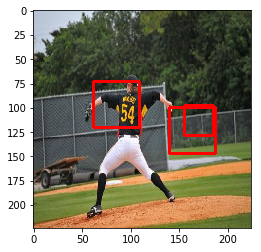

In [14]:
faces_stack[0]
#final_images[1]        

for (x, y, w, h) in faces_stack[310]:
    color = (255, 0, 0) # BGR
    stroke = 2
    end_cord_x = x + w
    end_cord_y = y + h
    cv2.rectangle(final_images[310], (x, y), (end_cord_x, end_cord_y), color, stroke)

plt.imshow(final_images[310])

In [10]:
final_images_removed = final_images
final_images_removed_reshaped = np.asarray(final_images_removed).reshape(-1, 224*224, 3)
final_ground_reshaped = np.asarray(final_ground).reshape(-1, 224*224)
for n in range(1043):
    if n%100 == 0:
        print(n)
    for i in range(224*224):
        if final_ground_reshaped[n][i] == 0:
            final_images_removed_reshaped[n][i] = 1

0
100
200
300
400
500
600
700
800
900
1000


In [11]:
final_image_removed = np.asarray(final_images_removed_reshaped).reshape(-1, 224, 224, 3) 

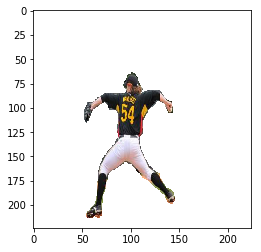

In [12]:
plt.imshow(final_image_removed[310])

In [ ]:
test_image = final_images[166]
test_label = final_ground[166]

test_image = imread(folders + 'train_images' + '\\' + 'image51.jpg')
test_image = resize(test_image, (224,224,3))
test_label = imread(folders + 'labels_images' + '\\' + 'image51.png') 
test_label = resize(test_label, (224,224))

In [ ]:
plt.imshow(test_image) # image51.jpg == 166

In [ ]:
import skimage.segmentation as seg

image_slic = seg.slic(test_image, n_segments = 350, compactness = 5, sigma = 0.7) #350, 5, 0.7 #350, 10, 0.7
image_overlay = color.label2rgb(image_slic, test_image, kind='overlay')
plt.imshow(image_overlay)

In [ ]:
labeled_slic = []
test_label_reshaped = test_label.reshape(224*224)
image_slic_reshaped = image_slic.reshape(224*224)
empty_stack = []
counter = 0
c = 0

for i in range(np.asarray(image_slic_reshaped).shape[0]):
    if counter == image_slic_reshaped[i]:
        empty_stack = np.append(empty_stack, test_label_reshaped[i])#np.asarray()
        
    elif counter != image_slic_reshaped[i]:# or i == np.asarray(image_slic_reshaped).shape[0]:

        c = c + np.asarray(empty_stack).shape[0]
        m = np.mean(empty_stack)
        r_m = np.round(m)
        if r_m == 0:
            empty_stack = np.zeros(np.asarray(empty_stack).shape[0]) 
        elif r_m == 1:
            empty_stack = np.ones(np.asarray(empty_stack).shape[0])
        labeled_slic = np.hstack((labeled_slic, empty_stack))
        empty_stack = [1.]
        counter = image_slic_reshaped[i]
        
labeled_slic = np.hstack((labeled_slic, empty_stack))      
print(c)

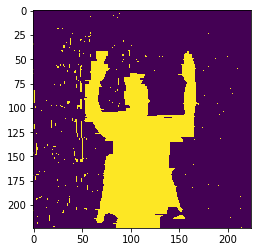

In [8]:
ls = labeled_slic.reshape(224,224)
plt.imshow(ls)
image_overlay = color.label2rgb(ls, test_label, kind='overlay')
#plt.imshow(image_overlay)

In [124]:
coord_array = []
coord_stack = [] #np.zeros((1044, 224*224))
#coord_array = np.asarray(coord_array)
final_ground_reshaped = np.asarray(final_ground).reshape(-1, 224*224)
for n in range(1043):
    if n%100==0:
        print(n)
    for i in range(224*224):
        if final_ground_reshaped[n][i] != 0:
            coord_array.append((i%224, i//224))
            #print(i)
    coord_stack.append(coord_array)
    coord_array = []

0
100
200
300
400
500
600
700
800
900
1000


In [128]:
print(np.asarray(coord_stack).shape)
print(np.asarray(coord_stack[2]).shape)
#coord_stack_reshaped = coord_stack.reshaped(-1, 2)
coord_stack[2]

(1043,)
(19703, 2)


[(94, 2),
 (95, 2),
 (96, 2),
 (97, 2),
 (98, 2),
 (88, 3),
 (89, 3),
 (90, 3),
 (91, 3),
 (92, 3),
 (93, 3),
 (94, 3),
 (95, 3),
 (96, 3),
 (97, 3),
 (98, 3),
 (99, 3),
 (100, 3),
 (101, 3),
 (102, 3),
 (103, 3),
 (104, 3),
 (105, 3),
 (106, 3),
 (107, 3),
 (85, 4),
 (86, 4),
 (87, 4),
 (88, 4),
 (89, 4),
 (90, 4),
 (91, 4),
 (92, 4),
 (93, 4),
 (94, 4),
 (95, 4),
 (96, 4),
 (97, 4),
 (98, 4),
 (99, 4),
 (100, 4),
 (101, 4),
 (102, 4),
 (103, 4),
 (104, 4),
 (105, 4),
 (106, 4),
 (107, 4),
 (108, 4),
 (109, 4),
 (83, 5),
 (84, 5),
 (85, 5),
 (86, 5),
 (87, 5),
 (88, 5),
 (89, 5),
 (90, 5),
 (91, 5),
 (92, 5),
 (93, 5),
 (94, 5),
 (95, 5),
 (96, 5),
 (97, 5),
 (98, 5),
 (99, 5),
 (100, 5),
 (101, 5),
 (102, 5),
 (103, 5),
 (104, 5),
 (105, 5),
 (106, 5),
 (107, 5),
 (108, 5),
 (109, 5),
 (110, 5),
 (79, 6),
 (80, 6),
 (81, 6),
 (82, 6),
 (83, 6),
 (84, 6),
 (85, 6),
 (86, 6),
 (87, 6),
 (88, 6),
 (89, 6),
 (90, 6),
 (91, 6),
 (92, 6),
 (93, 6),
 (94, 6),
 (95, 6),
 (96, 6),
 (97, 6),
 

In [113]:
print(np.asarray(coord_stack[0][0]).shape, 1043*224*224)
coord_stack[0]
print(50115//224, 224*(224-163), 50115+(224-163), 132%224) # i % 224 = No of row # i // 224 = No of col

() 52333568
223 13664 50176 132


(1043, 50176)
(1043, 50176)


TypeError: Invalid dimensions for image data

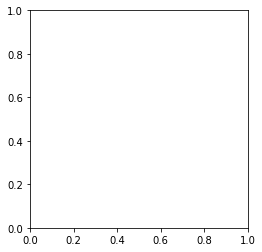

In [63]:
print(final_ground_reshaped.shape)

final_ground_reshaped = final_ground_reshaped.reshape(-1, 224*224)
#final_ground_reshaped = final_ground_reshaped.reshape(-1, 224,224)
print(final_ground_reshaped.shape)
plt.imshow(final_ground_reshaped[0])

In [6]:
def felz(im):
    gray = color.rgb2gray(im)
    gray = np.uint8(gray*255)
    edges = feat.canny(gray, sigma=1.95)
    #edges = cv2.Canny(gray, 250, 250)
    image_felzenszwalb_colored = color.label2rgb(edges, im, kind='overlay')
    return image_felzenszwalb_colored

In [8]:
for i in range(np.asarray(final_images).shape[0]):
    final_images[i] = felz(final_images[i])

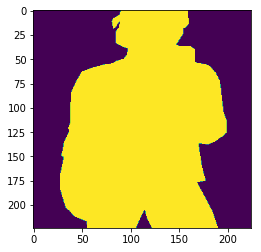

In [10]:
plt.imshow(final_ground[410])

In [51]:
# STARTS FROM HERE!

In [22]:
print(final_ground_reshaped.shape)

(1043, 224, 224)


In [75]:
tr_i = np.asarray(final_images).reshape(-1, 224, 224, 3)
#tr_g = np.asarray(final_ground_reshaped).reshape(-1, 224, 224, 1)
#tr_i = np.asarray(predicted).reshape(-1, 224, 224, 1)

tr_g = np.asarray(final_ground).reshape(-1, 224, 224, 1)
#tr_g = np.asarray(final_image_removed).reshape(-1, 224, 224, 3)

In [76]:
input_img = Input((224, 224, 3), name = 'img')

c1 = Conv2D(32, (3, 3), activation='relu', padding = 'same') (input_img)
c1 = Conv2D(32, (3, 3), activation='relu', padding = 'same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(64, (3, 3), activation='relu', padding = 'same') (p1)
c2 = Conv2D(64, (3, 3), activation='relu', padding = 'same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(128, (3, 3), activation='relu', padding = 'same') (p2)
c3 = Conv2D(128, (3, 3), activation='relu', padding = 'same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(256, (3, 3), activation='relu', padding = 'same') (p3)
c4 = Conv2D(256, (3, 3), activation='relu', padding = 'same') (c4)

u5 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding = 'same') (c4)
u5 = concatenate([u5, c3])
c6 = Conv2D(128, (3, 3), activation='relu', padding = 'same') (u5)
c6 = Conv2D(128, (3, 3), activation='relu', padding = 'same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding = 'same') (c6)
u7 = concatenate([u7, c2])
c7 = Conv2D(64, (3, 3), activation='relu', padding = 'same') (u7)
c7 = Conv2D(64, (3, 3), activation='relu', padding = 'same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding = 'same') (c7)
u8 = concatenate([u8, c1])
c8 = Conv2D(32, (3, 3), activation='relu', padding = 'same') (u8)
c8 = Conv2D(32, (3, 3), activation='relu', padding = 'same') (c8)
 
outputs = Conv2D(1, (1, 1), activation = 'relu') (c8)

In [77]:
model = Model(inputs = input_img, outputs = outputs)#, loss = 'binary_crossentropy')
model.compile(optimizer = "adam", loss = 'binary_crossentropy' , metrics = ['binary_accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 224, 224, 32)      9248      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 112, 112, 64)      18496     
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 56, 56, 64)        0         
__________

In [87]:
epochs = 3
batch_size = 16

In [88]:
model.fit(tr_i, tr_g, batch_size = batch_size, epochs = epochs)

Epoch 1/3
1043/1043 [==============================] - 1076s - loss: 0.5151 - binary_accuracy: 0.7284  
Epoch 2/3
1043/1043 [==============================] - 1074s - loss: 0.4899 - binary_accuracy: 0.7398  
Epoch 3/3
1043/1043 [==============================] - 1062s - loss: 0.4673 - binary_accuracy: 0.7585  


In [93]:
test_image = final_images[310]#cv2.imread("logo.png")
test_image_resized = resize(test_image, (224, 224, 3))
float_image = test_image_resized.astype('float32')
im = float_image.reshape(-1,224,224,3)
pred = model.predict(im)

(1, 224, 224, 1)
(1, 224, 224, 1)


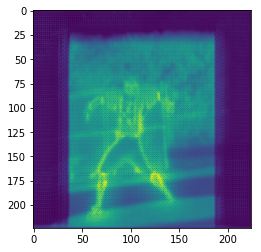

In [94]:
print(pred.shape)
#pred = np.transpose(pred, (3, 1, 2, 0))
#pred = pred.mean(axis=0)
print(pred.shape)
plt.imshow(pred.reshape(224, 224))#, cmap='gray')

In [92]:
image_slic_1d = image_slic#.resize(224*224)
#print(image_slic.shape)
image_pred_1d = pred#.resize(224*224)

counter = 0
slic_array = np.vstack((image_slic_1d,image_pred_1d))
print(slic_array.shape)
for i in range(np.asarray(image_slic_1d).shape[0]):
    if image_pred_1d[i] == 0:
        slic_array[i, image_slic_1d[i]] = 0
    elif image_pred_1d[i] == 1:
        slic_array[i, image_slic_1d[i]] = 1



(2, 50176)


IndexError: index 2 is out of bounds for axis 0 with size 2

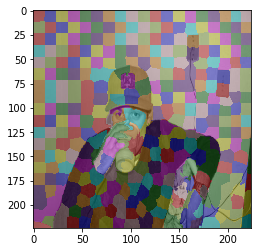

In [221]:
import skimage.segmentation as seg
img = final_images[210]
image_slic = seg.slic(img, n_segments = 215, compactness = 10, sigma = 1) 
image_overlay = color.label2rgb(image_slic, img, kind='overlay')
plt.imshow(image_overlay)
#print(image_slic)

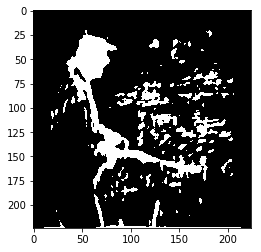

In [34]:
pred = pred.reshape(224, 224)
#pred = 1/(1+np.exp(-pred))
#plt.imshow(pred)

pred[pred <= 0.43] = 0
pred[pred > 0.43] = 1
plt.imshow(pred, cmap='gray')

In [112]:
predicted = []
for i in range(np.asarray(np.asarray(final_images).shape[0])):
    test_image = final_images[i]
    float_image = test_image.astype('float32')
    im = float_image.reshape(-1,224,224,3)
    pred = model.predict(im)
    pred = pred.reshape(224, 224)
    pred[pred <= 0.3] = 0
    pred[pred > 0.3] = 1
    predicted.append(pred)
    
#pred = pred.reshape(224,224,3)
#print(np.asarray(pred).shape)

(224, 224, 1)


TypeError: Invalid dimensions for image data

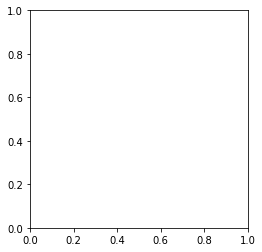

In [55]:
tr_i = np.asarray(predicted).reshape(-1, 224, 224, 1)
print(np.asarray(pred[1]).shape)
plt.imshow(pred, cmap='gray')

In [145]:
predicted = []
for i in range(np.asarray(final_images).shape[0]):
    if i % 50 == 0:
        print(i)
    test_image = final_images[i]
    float_image = test_image.astype('float32')
    im = float_image.reshape(-1,224,224,1)
    pred = model.predict(im)
    predicted.append(pred)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000


In [179]:
#val_image = cv2.imread("D:\\Marko\\ML\\coding examples\\Databases\\BG removing\\XPIE\\Image\\Y_E_348.jpg")
#val_image = resize(val_image, (224, 224))
test_image = tr_i[410]
print(tr_i[410].shape)

(224, 224, 1)


In [181]:
val_image = test_image.astype("float32")

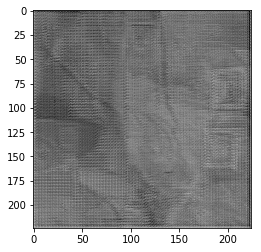

In [191]:
im = val_image.reshape(-1, 224, 224, 1)
plt.imshow(test_image, cmap='gray')#.resize(224,224))

In [159]:
im = im.mean(axis=3)
im = im.reshape(-1, 224, 224, 1)
print(im.shape)

(1, 224, 224, 1)


In [160]:
pred = model.predict(im)

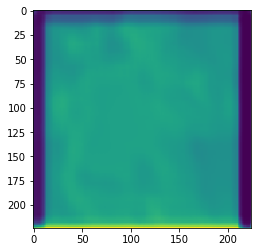

In [95]:
plt.imshow(pred)

In [72]:
def show_image(images):
    for i in range(2):
        curr_img = np.reshape(images[i], (224, 224))
        plt.imshow(curr_img, cmap = "gray")
        plt.show()
#show_image(pred)

In [5]:
input_images = []
for i in range(np.asarray(final_images).shape[0]):
    if i % 50 == 0:
        print(i)
    test_image = final_images[i]
    gray = color.rgb2gray(test_image)
    gray = np.uint8(gray*255)
    #edges = feat.canny(gray, sigma=0.5)
    edges = cv2.Canny(gray, 50, 50)
    image_felzenszwalb_colored = color.label2rgb(edges, test_image, kind='overlay')
    input_images.append(image_felzenszwalb_colored)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000


In [58]:
# input layer
input_layer = Input(shape = (224, 224, 3))

# encoding architecture
encoded_layer1 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(input_layer)
encoded_layer1 = MaxPool2D( (2, 2), padding = 'same')(encoded_layer1)
encoded_layer2 = Conv2D(32, (3, 3), activation ='relu', padding='same')(encoded_layer1)
encoded_layer2 = MaxPool2D( (2, 2), padding = 'same')(encoded_layer2)
encoded_layer3 = Conv2D(16, (3, 3), activation = 'relu', padding='same')(encoded_layer2)
latent_view    = MaxPool2D( (2, 2), padding = 'same')(encoded_layer3)

# decoding architecture
decoded_layer1 = Conv2D(16, (3, 3), activation = 'relu', padding='same')(latent_view)
decoded_layer1 = UpSampling2D((2, 2))(decoded_layer1)
decoded_layer2 = Conv2D(32, (3, 3), activation = 'relu', padding='same')(decoded_layer1)
decoded_layer2 = UpSampling2D((2, 2))(decoded_layer2)
decoded_layer3 = Conv2D(64, (1, 1), activation = 'relu')(decoded_layer2)
decoded_layer3 = UpSampling2D((2, 2))(decoded_layer3)
output_layer   = Conv2D(3, (3, 3), padding = 'same', activation = 'relu')(decoded_layer3)

model = Model(input_layer, output_layer)
model.compile(optimizer = 'adam', loss = "mse", metrics = ['binary_accuracy'])

In [59]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 112, 112, 32)      18464     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 56, 56, 16)        4624      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 28, 28, 16)        0         
__________

In [60]:
model.fit(tr_i, tr_g, batch_size = 16, epochs = 1)

Epoch 1/1
1043/1043 [==============================] - 392s - loss: 0.1762 - binary_accuracy: 0.5600   


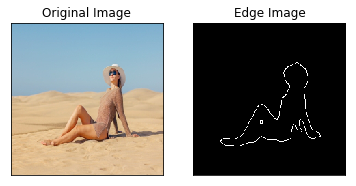

(224, 224, 3)


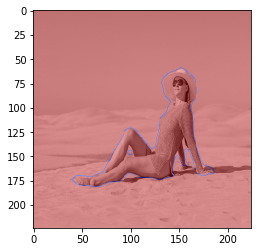

In [99]:
#### img = cv2.imread('messi5.jpg',0)
im = final_images[110]
gr = final_ground[110]
gray = color.rgb2gray(gr)
gray = np.uint8(gray*255)
#edges = feat.canny(gray, sigma=0.5)
edges = cv2.Canny(gray, 50, 50)

plt.subplot(121),plt.imshow(im,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

plt.show()

image_felzenszwalb_colored = color.label2rgb(edges, im, kind='overlay')
image_felzenszwalb_colored = color.label2rgb(edges, im, kind='overlay')
'''
im_felz = color.rgb2gray(image_felzenszwalb_colored)

float_image = im.astype('float32')
reshaped_image = float_image.reshape(-1,224,224,3)
pred = model.predict(reshaped_image)
pred = pred.reshape(224,224)
image_felzenszwalb_colored = color.label2rgb(im_felz, pred, kind='overlay')
'''
print(image_felzenszwalb_colored.shape)
plt.imshow(image_felzenszwalb_colored);